# IMPORTS

In [1]:
!pip install torch torchvision timm matplotlib numpy
!pip install overcomplete

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random
import time
from collections import defaultdict

# pip install overcomplete
from overcomplete.sae import TopKSAE
from overcomplete.metrics import l0_eps, r2_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
LR = 3e-4
DICT_SIZE = 4096
K = 32
EPOCHS = 25
CLIP_GRAD = 1.0

print("="*70)
print("UNIVERSAL SAE IMPLEMENTATION")
print("="*70)
print(f"Device: {DEVICE}")
print(f"Dictionary Size: {DICT_SIZE}")
print(f"TopK: {K}")
print(f"Epochs: {EPOCHS}")
print("="*70)

UNIVERSAL SAE IMPLEMENTATION
Device: cuda
Dictionary Size: 4096
TopK: 32
Epochs: 25


# DATASETS & MODELS

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

print(f"✅ Dataset: {len(dataset)} samples")


# 2. Load Models
model_resnet = torchvision.models.resnet18(pretrained=True).to(DEVICE)
model_vit = timm.create_model('vit_tiny_patch16_224', pretrained=True).to(DEVICE)
model_resnet.eval()
model_vit.eval()

print("done")

100%|██████████| 170M/170M [00:04<00:00, 41.8MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weig

✅ Dataset: 50000 samples
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 82.9MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

done


In [4]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        if len(output.shape) == 4:
            activations[name] = output.mean(dim=[2, 3])
        elif len(output.shape) == 3:
            activations[name] = output[:, 0, :]
        else:
            activations[name] = output
    return hook

model_resnet.layer4.register_forward_hook(get_activation('resnet'))
model_vit.norm.register_forward_hook(get_activation('vit'))

# Get dimensions
with torch.no_grad():
    dummy = torch.randn(1, 3, 224, 224).to(DEVICE)
    model_resnet(dummy)
    model_vit(dummy)
    D_RESNET = activations['resnet'].shape[1]
    D_VIT = activations['vit'].shape[1]

print(f"✅ Dimensions: ResNet={D_RESNET}, ViT={D_VIT}")

✅ Dimensions: ResNet=512, ViT=192


# USAE

In [5]:
print("\nComputing global statistics...")
res_acts_list = []
vit_acts_list = []

with torch.no_grad():
    for i, (imgs, _) in enumerate(tqdm(loader, desc="Stats")):
        imgs = imgs.to(DEVICE)
        model_resnet(imgs)
        model_vit(imgs)
        res_acts_list.append(activations['resnet'].cpu())
        vit_acts_list.append(activations['vit'].cpu())
        if i >= 100:
            break

res_all = torch.cat(res_acts_list, dim=0)
vit_all = torch.cat(vit_acts_list, dim=0)

RES_MEAN = res_all.mean(0).to(DEVICE)
RES_STD = res_all.std(0).to(DEVICE)
VIT_MEAN = vit_all.mean(0).to(DEVICE)
VIT_STD = vit_all.std(0).to(DEVICE)

print(f"✅ Stats computed from {res_all.shape[0]} samples")


Computing global statistics...


Stats:  26%|██▌       | 100/390 [00:29<01:25,  3.41it/s]

✅ Stats computed from 12928 samples


In [6]:
print("\n" + "="*70)
print("INITIALIZING UNIVERSAL SAEs")
print("="*70)

saes = {
    'resnet': TopKSAE(
        input_shape=D_RESNET,
        nb_concepts=DICT_SIZE,
        top_k=K,
        device=DEVICE
    ),
    'vit': TopKSAE(
        input_shape=D_VIT,
        nb_concepts=DICT_SIZE,
        top_k=K,
        device=DEVICE
    )
}

sae_optimizers = {
    'resnet': optim.Adam(saes['resnet'].parameters(), lr=LR),
    'vit': optim.Adam(saes['vit'].parameters(), lr=LR)
}

sae_schedulers = {
    'resnet': optim.lr_scheduler.CosineAnnealingLR(
        sae_optimizers['resnet'], T_max=EPOCHS * len(loader), eta_min=1e-6
    ),
    'vit': optim.lr_scheduler.CosineAnnealingLR(
        sae_optimizers['vit'], T_max=EPOCHS * len(loader), eta_min=1e-6
    )
}

print(f"✅ SAEs initialized")



INITIALIZING UNIVERSAL SAEs
✅ SAEs initialized


In [7]:
# ==================== TEST TopK ====================
print("\n" + "="*70)
print("TESTING TopK FUNCTIONALITY")
print("="*70)

# Get one batch
test_imgs, _ = next(iter(loader))
test_imgs = test_imgs.to(DEVICE)

with torch.no_grad():
    model_resnet(test_imgs)
    test_act = (activations['resnet'] - RES_MEAN) / (RES_STD + 1e-6)

    print(f"Test activation shape: {test_act.shape}")
    print(f"Test activation range: [{test_act.min():.2f}, {test_act.max():.2f}]")

    # Test encode
    z_pre, z = saes['resnet'].encode(test_act)

    print(f"\nAfter encode:")
    print(f"z_pre shape: {z_pre.shape}")
    print(f"z shape: {z.shape}")
    print(f"z non-zero per sample: {(z != 0).sum(dim=-1)}")
    print(f"Expected: {K} non-zero per sample")

    if (z != 0).sum(dim=-1).max() != K:
        print(f"\n🔴 ERROR: TopK is not working! Expected {K}, got {(z != 0).sum(dim=-1).max()}")
    else:
        print(f"\n✅ TopK is working correctly!")

print("="*70)


TESTING TopK FUNCTIONALITY
Test activation shape: torch.Size([128, 512])
Test activation range: [-2.49, 13.34]

After encode:
z_pre shape: torch.Size([128, 4096])
z shape: torch.Size([128, 4096])
z non-zero per sample: tensor([32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32], device='cuda:0')
Expected: 32 non-zero per sample

✅ TopK is working correctly!


In [8]:
def usae_criterion(x, x_hat, pre_codes, codes, dictionary):
    """MSE loss matching official implementation"""
    mse = (x - x_hat).square().mean()
    return mse

In [9]:
def train_usae(saes, dataloader, criterion, sae_optimizers, sae_schedulers,
               model_zoo, nb_epochs=50, clip_grad=1.0, monitoring=1, device='cpu'):
    """Train Universal Sparse Autoencoders"""
    logs = defaultdict(list)
    random.seed(10)

    model_names = list(saes.keys())

    for epoch in range(nb_epochs):
        for sae in saes.values():
            sae.train()

        start_time = time.time()
        epoch_loss = 0.0
        epoch_sparsity = 0.0
        batch_count = 0

        r2_matrix = np.zeros((len(model_names), len(model_names)))
        r2_counts = np.zeros((len(model_names), len(model_names)))

        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{nb_epochs}")

        for imgs, _ in pbar:
            batch_count += 1
            imgs = imgs.to(device, non_blocking=True)

            with torch.no_grad():
                model_zoo['resnet'](imgs)
                model_zoo['vit'](imgs)

                batch_set = {
                    'resnet': (activations['resnet'] - RES_MEAN) / (RES_STD + 1e-6),
                    'vit': (activations['vit'] - VIT_MEAN) / (VIT_STD + 1e-6)
                }

            i = random.randint(0, len(batch_set) - 1)
            model_i = model_names[i]

            sae_optimizers[model_i].zero_grad()

            A_i = batch_set[model_i]
            z_pre_i, z_i = saes[model_i].encode(A_i)

            loss = 0.0
            for j, model_j in enumerate(model_names):
                A_j = batch_set[model_j]
                A_hat_j = saes[model_j].decode(z_i)

                loss_j = criterion(A_j, A_hat_j, z_pre_i, z_i, saes[model_j].get_dictionary())
                loss += loss_j

                if monitoring:
                    with torch.no_grad():
                        r2 = r2_score(A_j, A_hat_j).item()
                        r2_matrix[i, j] += r2
                        r2_counts[i, j] += 1

            loss.backward()

            if clip_grad:
                torch.nn.utils.clip_grad_norm_(saes[model_i].parameters(), clip_grad)

            sae_optimizers[model_i].step()

            if sae_schedulers[model_i] is not None:
                sae_schedulers[model_i].step()

            if monitoring:
                epoch_loss += loss.item()
                # FIXED: Direct calculation instead of l0_eps
                batch_l0 = (z_i != 0).float().sum(dim=-1).mean().item()
                epoch_sparsity += batch_l0
                logs['step_loss'].append(loss.item())

            pbar.set_postfix(loss=loss.item(), l0=batch_l0, source=model_i)

        if monitoring and batch_count > 0:
            avg_loss = epoch_loss / batch_count
            avg_sparsity = epoch_sparsity / batch_count

            r2_matrix_avg = np.divide(r2_matrix, r2_counts,
                                     where=r2_counts > 0,
                                     out=np.zeros_like(r2_matrix))

            diagonal_r2 = np.mean([r2_matrix_avg[i, i] for i in range(len(model_names))])
            off_diag = [r2_matrix_avg[i, j] for i in range(len(model_names))
                       for j in range(len(model_names)) if i != j]
            offdiag_r2 = np.mean(off_diag)

            epoch_duration = time.time() - start_time

            logs['avg_loss'].append(avg_loss)
            logs['z_sparsity'].append(avg_sparsity)
            logs['time_epoch'].append(epoch_duration)
            logs['diagonal_r2'].append(diagonal_r2)
            logs['offdiag_r2'].append(offdiag_r2)
            logs['r2_matrix'].append(r2_matrix_avg)

            print(f"Epoch [{epoch+1}/{nb_epochs}] - "
                  f"Loss: {avg_loss:.4f}, "
                  f"R²_diag: {diagonal_r2:.4f}, "
                  f"R²_offdiag: {offdiag_r2:.4f}, "
                  f"L0: {avg_sparsity:.1f}, "
                  f"Time: {epoch_duration:.2f}s")

    return logs

In [10]:
print("\n" + "="*70)
print("TRAINING UNIVERSAL SPARSE AUTOENCODER")
print("="*70)

model_zoo_dict = {
    'resnet': model_resnet,
    'vit': model_vit
}

logs = train_usae(
    saes=saes,
    dataloader=loader,
    criterion=usae_criterion,
    sae_optimizers=sae_optimizers,
    sae_schedulers=sae_schedulers,
    model_zoo=model_zoo_dict,
    nb_epochs=EPOCHS,
    clip_grad=CLIP_GRAD,
    monitoring=1,
    device=DEVICE
)

print("\n✅ Training Complete!")


TRAINING UNIVERSAL SPARSE AUTOENCODER


Epoch 1/25: 100%|██████████| 390/390 [01:51<00:00,  3.48it/s, l0=32, loss=1.79, source=resnet]


Epoch [1/25] - Loss: 2.1095, R²_diag: -0.0071, R²_offdiag: -0.1028, L0: 32.0, Time: 111.93s


Epoch 2/25: 100%|██████████| 390/390 [01:51<00:00,  3.51it/s, l0=32, loss=1.38, source=vit]


Epoch [2/25] - Loss: 1.5631, R²_diag: 0.3167, R²_offdiag: 0.1191, L0: 32.0, Time: 111.22s


Epoch 3/25: 100%|██████████| 390/390 [01:48<00:00,  3.60it/s, l0=32, loss=1.36, source=resnet]


Epoch [3/25] - Loss: 1.3376, R²_diag: 0.4499, R²_offdiag: 0.2143, L0: 32.0, Time: 108.46s


Epoch 4/25: 100%|██████████| 390/390 [01:45<00:00,  3.68it/s, l0=32, loss=1.11, source=vit]


Epoch [4/25] - Loss: 1.2179, R²_diag: 0.5183, R²_offdiag: 0.2584, L0: 32.0, Time: 105.97s


Epoch 5/25: 100%|██████████| 390/390 [01:50<00:00,  3.52it/s, l0=32, loss=1.07, source=vit]


Epoch [5/25] - Loss: 1.1603, R²_diag: 0.5571, R²_offdiag: 0.2818, L0: 32.0, Time: 110.78s


Epoch 6/25: 100%|██████████| 390/390 [01:49<00:00,  3.57it/s, l0=32, loss=1.19, source=resnet]


Epoch [6/25] - Loss: 1.1227, R²_diag: 0.5810, R²_offdiag: 0.2970, L0: 32.0, Time: 109.30s


Epoch 7/25: 100%|██████████| 390/390 [01:51<00:00,  3.51it/s, l0=32, loss=1.04, source=vit]


Epoch [7/25] - Loss: 1.0956, R²_diag: 0.5979, R²_offdiag: 0.3069, L0: 32.0, Time: 111.06s


Epoch 8/25: 100%|██████████| 390/390 [01:43<00:00,  3.78it/s, l0=32, loss=1.13, source=resnet]


Epoch [8/25] - Loss: 1.0671, R²_diag: 0.6105, R²_offdiag: 0.3146, L0: 32.0, Time: 103.14s


Epoch 9/25: 100%|██████████| 390/390 [01:46<00:00,  3.67it/s, l0=32, loss=0.95, source=vit]


Epoch [9/25] - Loss: 1.0585, R²_diag: 0.6214, R²_offdiag: 0.3191, L0: 32.0, Time: 106.24s


Epoch 10/25: 100%|██████████| 390/390 [01:44<00:00,  3.74it/s, l0=32, loss=0.999, source=vit]


Epoch [10/25] - Loss: 1.0412, R²_diag: 0.6296, R²_offdiag: 0.3244, L0: 32.0, Time: 104.25s


Epoch 11/25: 100%|██████████| 390/390 [01:43<00:00,  3.75it/s, l0=32, loss=0.975, source=vit]


Epoch [11/25] - Loss: 1.0319, R²_diag: 0.6373, R²_offdiag: 0.3278, L0: 32.0, Time: 104.01s


Epoch 12/25: 100%|██████████| 390/390 [01:44<00:00,  3.74it/s, l0=32, loss=1.1, source=resnet]


Epoch [12/25] - Loss: 1.0241, R²_diag: 0.6441, R²_offdiag: 0.3306, L0: 32.0, Time: 104.30s


Epoch 13/25: 100%|██████████| 390/390 [01:46<00:00,  3.67it/s, l0=32, loss=0.96, source=vit]


Epoch [13/25] - Loss: 1.0144, R²_diag: 0.6497, R²_offdiag: 0.3337, L0: 32.0, Time: 106.15s


Epoch 14/25: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s, l0=32, loss=0.94, source=vit]


Epoch [14/25] - Loss: 1.0064, R²_diag: 0.6547, R²_offdiag: 0.3369, L0: 32.0, Time: 105.62s


Epoch 15/25: 100%|██████████| 390/390 [01:44<00:00,  3.74it/s, l0=32, loss=1.02, source=resnet]


Epoch [15/25] - Loss: 1.0005, R²_diag: 0.6597, R²_offdiag: 0.3390, L0: 32.0, Time: 104.29s


Epoch 16/25: 100%|██████████| 390/390 [01:43<00:00,  3.76it/s, l0=32, loss=1.07, source=resnet]


Epoch [16/25] - Loss: 0.9909, R²_diag: 0.6644, R²_offdiag: 0.3424, L0: 32.0, Time: 103.68s


Epoch 17/25: 100%|██████████| 390/390 [01:45<00:00,  3.69it/s, l0=32, loss=1.05, source=resnet]


Epoch [17/25] - Loss: 0.9885, R²_diag: 0.6690, R²_offdiag: 0.3441, L0: 32.0, Time: 105.82s


Epoch 18/25: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s, l0=32, loss=0.907, source=vit]


Epoch [18/25] - Loss: 0.9791, R²_diag: 0.6729, R²_offdiag: 0.3465, L0: 32.0, Time: 105.42s


Epoch 19/25: 100%|██████████| 390/390 [01:44<00:00,  3.75it/s, l0=32, loss=1.02, source=resnet]


Epoch [19/25] - Loss: 0.9741, R²_diag: 0.6767, R²_offdiag: 0.3487, L0: 32.0, Time: 104.12s


Epoch 20/25: 100%|██████████| 390/390 [01:44<00:00,  3.75it/s, l0=32, loss=0.954, source=vit]


Epoch [20/25] - Loss: 0.9682, R²_diag: 0.6803, R²_offdiag: 0.3509, L0: 32.0, Time: 104.04s


Epoch 21/25: 100%|██████████| 390/390 [01:43<00:00,  3.77it/s, l0=32, loss=0.963, source=vit]


Epoch [21/25] - Loss: 0.9619, R²_diag: 0.6833, R²_offdiag: 0.3533, L0: 32.0, Time: 103.43s


Epoch 22/25: 100%|██████████| 390/390 [01:45<00:00,  3.70it/s, l0=32, loss=0.929, source=vit]


Epoch [22/25] - Loss: 0.9590, R²_diag: 0.6866, R²_offdiag: 0.3545, L0: 32.0, Time: 105.48s


Epoch 23/25: 100%|██████████| 390/390 [01:44<00:00,  3.73it/s, l0=32, loss=0.993, source=resnet]


Epoch [23/25] - Loss: 0.9535, R²_diag: 0.6892, R²_offdiag: 0.3573, L0: 32.0, Time: 104.68s


Epoch 24/25: 100%|██████████| 390/390 [01:44<00:00,  3.73it/s, l0=32, loss=0.93, source=vit]


Epoch [24/25] - Loss: 0.9471, R²_diag: 0.6917, R²_offdiag: 0.3590, L0: 32.0, Time: 104.63s


Epoch 25/25: 100%|██████████| 390/390 [01:44<00:00,  3.75it/s, l0=32, loss=0.936, source=vit]

Epoch [25/25] - Loss: 0.9434, R²_diag: 0.6946, R²_offdiag: 0.3608, L0: 32.0, Time: 104.13s

✅ Training Complete!


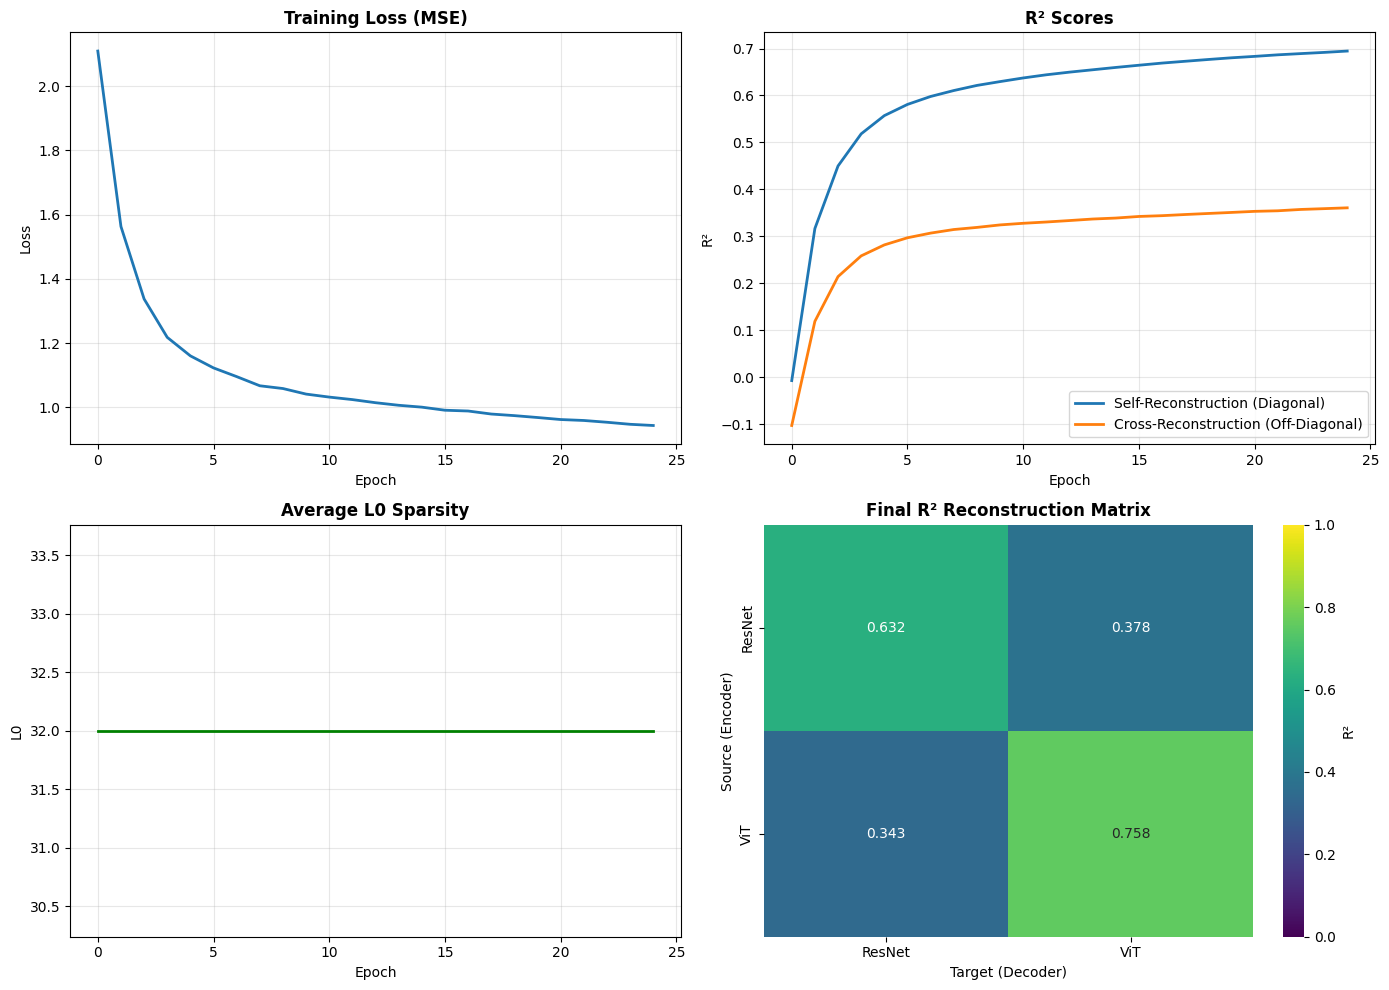

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curve
axes[0, 0].plot(logs['avg_loss'], linewidth=2)
axes[0, 0].set_title('Training Loss (MSE)', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(alpha=0.3)

# R² curves
axes[0, 1].plot(logs['diagonal_r2'], label='Self-Reconstruction (Diagonal)', linewidth=2)
axes[0, 1].plot(logs['offdiag_r2'], label='Cross-Reconstruction (Off-Diagonal)', linewidth=2)
axes[0, 1].set_title('R² Scores', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('R²')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Sparsity
axes[1, 0].plot(logs['z_sparsity'], linewidth=2, color='green')
axes[1, 0].set_title('Average L0 Sparsity', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('L0')
axes[1, 0].grid(alpha=0.3)

# Final R² matrix
final_r2 = logs['r2_matrix'][-1]
sns.heatmap(final_r2, annot=True, fmt='.3f',
            xticklabels=['ResNet', 'ViT'],
            yticklabels=['ResNet', 'ViT'],
            cmap='viridis', vmin=0, vmax=1,
            ax=axes[1, 1], cbar_kws={'label': 'R²'})
axes[1, 1].set_title('Final R² Reconstruction Matrix', fontweight='bold')
axes[1, 1].set_ylabel('Source (Encoder)')
axes[1, 1].set_xlabel('Target (Decoder)')

plt.tight_layout()
plt.savefig('usae_training_results.png', dpi=150)
plt.show()

In [12]:
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"Final Loss: {logs['avg_loss'][-1]:.4f}")
print(f"Final Diagonal R²: {logs['diagonal_r2'][-1]:.4f}")
print(f"Final Off-Diagonal R²: {logs['offdiag_r2'][-1]:.4f}")
print(f"Final Sparsity (L0): {logs['z_sparsity'][-1]:.1f}")
print("\nFinal R² Matrix:")
print(final_r2)

if logs['diagonal_r2'][-1] > 0.75:
    print("\n✅ Good self-reconstruction!")
else:
    print("\n⚠️  Self-reconstruction needs improvement")

if logs['offdiag_r2'][-1] > 0.3:
    print("✅ UNIVERSALITY CONFIRMED!")
else:
    print("⚠️  Limited universality")


FINAL RESULTS
Final Loss: 0.9434
Final Diagonal R²: 0.6946
Final Off-Diagonal R²: 0.3608
Final Sparsity (L0): 32.0

Final R² Matrix:
[[0.63159149 0.37821616]
 [0.34330078 0.75761689]]

⚠️  Self-reconstruction needs improvement
✅ UNIVERSALITY CONFIRMED!


# QUANTIFYING UNIVERSALITY

In [13]:
# ==================== QUANTIFYING UNIVERSALITY ====================
print("\n" + "="*70)
print("QUANTIFYING UNIVERSALITY")
print("="*70)

# Set models to eval mode
for sae in saes.values():
    sae.eval()

# Accumulate activations for entropy calculation
feature_activations = torch.zeros(DICT_SIZE, 2).to(DEVICE)  # [Features, 2 Models]

print("\nCalculating Firing Entropy...")
with torch.no_grad():
    for imgs, _ in tqdm(loader, desc="Computing Firing Counts"):
        imgs = imgs.to(DEVICE)

        # Get activations
        model_resnet(imgs)
        model_vit(imgs)

        acts = {
            'resnet': (activations['resnet'] - RES_MEAN) / (RES_STD + 1e-6),
            'vit': (activations['vit'] - VIT_MEAN) / (VIT_STD + 1e-6)
        }

        # ✅ CHANGED: Use saes['resnet'] instead of usae
        z_pre_res, z_res = saes['resnet'].encode(acts['resnet'])
        feature_activations[:, 0] += (z_res > 0).float().sum(0)

        # ✅ CHANGED: Use saes['vit'] instead of usae
        z_pre_vit, z_vit = saes['vit'].encode(acts['vit'])
        feature_activations[:, 1] += (z_vit > 0).float().sum(0)

# Calculate Entropy
# P(i|k) = count(feature k, model i) / total_count(feature k)
probs = feature_activations / (feature_activations.sum(dim=1, keepdim=True) + 1e-8)
log_probs = torch.log(probs + 1e-8)

# Entropy formula: -sum(p * log p) / log M
entropy = -torch.sum(probs * log_probs, dim=1) / np.log(2)  # M=2

# Filter dead neurons
active_features = feature_activations.sum(1) > 0
valid_entropy = entropy[active_features].cpu().numpy()

print(f"✅ Active features: {active_features.sum().item()} / {DICT_SIZE}")
print(f"✅ Dead features: {(~active_features).sum().item()} / {DICT_SIZE}")


QUANTIFYING UNIVERSALITY

Calculating Firing Entropy...


Computing Firing Counts:   0%|          | 0/390 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Computing Firing Counts: 100%|██████████| 390/390 [01:36<00:00,  4.05it/s]


✅ Active features: 4096 / 4096
✅ Dead features: 0 / 4096


In [14]:
# ==================== ENTROPY STATISTICS ====================
print("\n" + "="*70)
print("FIRING ENTROPY STATISTICS")
print("="*70)

# Categorize features
universal_features = (entropy > 0.8) & active_features
model_specific_features = (entropy < 0.2) & active_features
mixed_features = (entropy >= 0.2) & (entropy <= 0.8) & active_features

print(f"Universal features (entropy > 0.8):     {universal_features.sum().item():>6} ({100*universal_features.sum().item()/active_features.sum().item():.1f}%)")
print(f"Model-specific features (entropy < 0.2): {model_specific_features.sum().item():>6} ({100*model_specific_features.sum().item()/active_features.sum().item():.1f}%)")
print(f"Mixed features (0.2 ≤ entropy ≤ 0.8):   {mixed_features.sum().item():>6} ({100*mixed_features.sum().item()/active_features.sum().item():.1f}%)")

print(f"\nMean entropy: {valid_entropy.mean():.4f}")
print(f"Median entropy: {np.median(valid_entropy):.4f}")
print(f"Std entropy: {valid_entropy.std():.4f}")


FIRING ENTROPY STATISTICS
Universal features (entropy > 0.8):       1910 (46.6%)
Model-specific features (entropy < 0.2):    518 (12.6%)
Mixed features (0.2 ≤ entropy ≤ 0.8):     1668 (40.7%)

Mean entropy: 0.6641
Median entropy: 0.7616
Std entropy: 0.3184


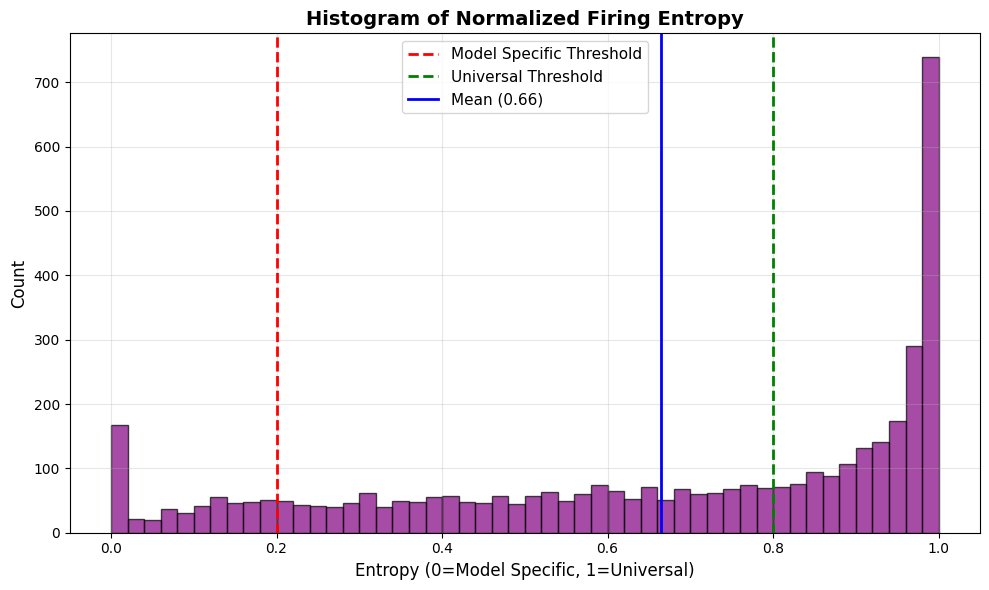

In [15]:
# ==================== PLOT ENTROPY HISTOGRAM ====================
plt.figure(figsize=(10, 6))
plt.hist(valid_entropy, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title("Histogram of Normalized Firing Entropy", fontsize=14, fontweight='bold')
plt.xlabel("Entropy (0=Model Specific, 1=Universal)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.axvline(x=0.2, color='r', linestyle='--', linewidth=2, label='Model Specific Threshold')
plt.axvline(x=0.8, color='g', linestyle='--', linewidth=2, label='Universal Threshold')
plt.axvline(x=valid_entropy.mean(), color='blue', linestyle='-', linewidth=2, label=f'Mean ({valid_entropy.mean():.2f})')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('firing_entropy_histogram.png', dpi=150)
plt.show()

In [16]:
# ==================== BIMODAL DISTRIBUTION ANALYSIS ====================
print("\n" + "="*70)
print("BIMODAL DISTRIBUTION ANALYSIS")
print("="*70)

# Check for bimodality using simple heuristic
low_entropy_count = (valid_entropy < 0.3).sum()
high_entropy_count = (valid_entropy > 0.7).sum()
mid_entropy_count = ((valid_entropy >= 0.3) & (valid_entropy <= 0.7)).sum()

print(f"Low entropy (< 0.3):  {low_entropy_count:>6} features")
print(f"Mid entropy (0.3-0.7): {mid_entropy_count:>6} features")
print(f"High entropy (> 0.7):  {high_entropy_count:>6} features")

if low_entropy_count > mid_entropy_count and high_entropy_count > mid_entropy_count:
    print("\n✅ BIMODAL DISTRIBUTION DETECTED!")
    print("   Interpretation: Features tend to be either model-specific OR universal,")
    print("   with fewer mixed features. This supports the Platonic Representation Hypothesis.")
else:
    print("\n⚠️  NO CLEAR BIMODAL DISTRIBUTION")
    print("   Interpretation: Features exist on a continuum from model-specific to universal.")


BIMODAL DISTRIBUTION ANALYSIS
Low entropy (< 0.3):     738 features
Mid entropy (0.3-0.7):   1116 features
High entropy (> 0.7):    2242 features

⚠️  NO CLEAR BIMODAL DISTRIBUTION
   Interpretation: Features exist on a continuum from model-specific to universal.


In [17]:
# ==================== CO-FIRING PROPORTION ====================
print("\n" + "="*70)
print("CO-FIRING PROPORTION ANALYSIS")
print("="*70)

cofiring_counts = 0
total_res_counts = 0
total_vit_counts = 0

with torch.no_grad():
    for imgs, _ in tqdm(loader, desc="Computing Co-Firing"):
        imgs = imgs.to(DEVICE)

        model_resnet(imgs)
        model_vit(imgs)

        acts = {
            'resnet': (activations['resnet'] - RES_MEAN) / (RES_STD + 1e-6),
            'vit': (activations['vit'] - VIT_MEAN) / (VIT_STD + 1e-6)
        }

        # ✅ CHANGED: Use saes dict and unpack both returns
        z_pre_res, z_res = saes['resnet'].encode(acts['resnet'])
        z_pre_vit, z_vit = saes['vit'].encode(acts['vit'])

        fires_res = (z_res > 0).float()
        fires_vit = (z_vit > 0).float()

        # Co-firing: both models activate the same feature
        cofiring_counts += (fires_res * fires_vit).sum().item()

        # Total firings
        total_res_counts += fires_res.sum().item()
        total_vit_counts += fires_vit.sum().item()

# Report all perspectives
cofiring_from_resnet = cofiring_counts / (total_res_counts + 1e-8)
cofiring_from_vit = cofiring_counts / (total_vit_counts + 1e-8)
cofiring_symmetric = cofiring_counts / ((total_res_counts + total_vit_counts) / 2 + 1e-8)

print(f"\nCo-Firing Proportion (ResNet baseline):  {cofiring_from_resnet:.4f}")
print(f"Co-Firing Proportion (ViT baseline):     {cofiring_from_vit:.4f}")
print(f"Co-Firing Proportion (Symmetric):        {cofiring_symmetric:.4f}")

# Interpretation
print("\nInterpretation:")
if cofiring_symmetric > 0.5:
    print("✅ HIGH co-firing (>0.5): Strong instance-level alignment!")
    print("   When a feature fires in one model, it likely fires in the other.")
elif cofiring_symmetric > 0.3:
    print("✅ MODERATE co-firing (0.3-0.5): Decent instance-level alignment.")
    print("   Features show some consistency across models.")
else:
    print("⚠️  LOW co-firing (<0.3): Limited instance-level alignment.")
    print("   Features may be universal but fire at different instances.")


CO-FIRING PROPORTION ANALYSIS


Computing Co-Firing: 100%|██████████| 390/390 [01:41<00:00,  3.85it/s]


Co-Firing Proportion (ResNet baseline):  0.3688
Co-Firing Proportion (ViT baseline):     0.3688
Co-Firing Proportion (Symmetric):        0.3688

Interpretation:
✅ MODERATE co-firing (0.3-0.5): Decent instance-level alignment.
   Features show some consistency across models.



PER-FEATURE CO-FIRING ANALYSIS


Per-Feature Co-Firing: 100%|██████████| 390/390 [01:36<00:00,  4.03it/s]


Mean per-feature co-firing rate: 0.0529
Median per-feature co-firing rate: 0.0000


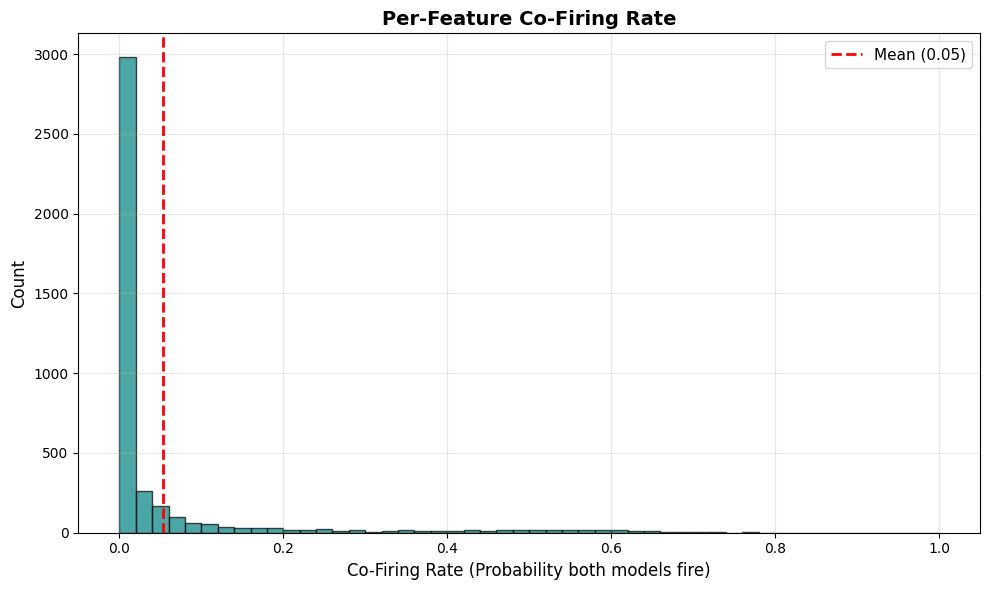

In [18]:
# ==================== PER-FEATURE CO-FIRING ANALYSIS ====================
print("\n" + "="*70)
print("PER-FEATURE CO-FIRING ANALYSIS")
print("="*70)

# Compute co-firing for each feature
feature_cofiring = torch.zeros(DICT_SIZE).to(DEVICE)
feature_res_fires = torch.zeros(DICT_SIZE).to(DEVICE)

with torch.no_grad():
    for imgs, _ in tqdm(loader, desc="Per-Feature Co-Firing"):
        imgs = imgs.to(DEVICE)

        model_resnet(imgs)
        model_vit(imgs)

        acts = {
            'resnet': (activations['resnet'] - RES_MEAN) / (RES_STD + 1e-6),
            'vit': (activations['vit'] - VIT_MEAN) / (VIT_STD + 1e-6)
        }

        z_pre_res, z_res = saes['resnet'].encode(acts['resnet'])
        z_pre_vit, z_vit = saes['vit'].encode(acts['vit'])

        fires_res = (z_res > 0).float()
        fires_vit = (z_vit > 0).float()

        # Per-feature co-firing
        feature_cofiring += (fires_res * fires_vit).sum(0)
        feature_res_fires += fires_res.sum(0)

# Co-firing rate per feature
cofiring_rate = feature_cofiring / (feature_res_fires + 1e-8)
cofiring_rate = cofiring_rate[active_features].cpu().numpy()

print(f"Mean per-feature co-firing rate: {cofiring_rate.mean():.4f}")
print(f"Median per-feature co-firing rate: {np.median(cofiring_rate):.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.hist(cofiring_rate, bins=50, alpha=0.7, color='teal', edgecolor='black')
plt.title("Per-Feature Co-Firing Rate", fontsize=14, fontweight='bold')
plt.xlabel("Co-Firing Rate (Probability both models fire)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.axvline(x=cofiring_rate.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean ({cofiring_rate.mean():.2f})')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('per_feature_cofiring.png', dpi=150)
plt.show()


ENTROPY vs CO-FIRING CORRELATION
Pearson correlation: 0.3450
✅ MODERATE positive correlation: Some relationship between universality and co-firing.


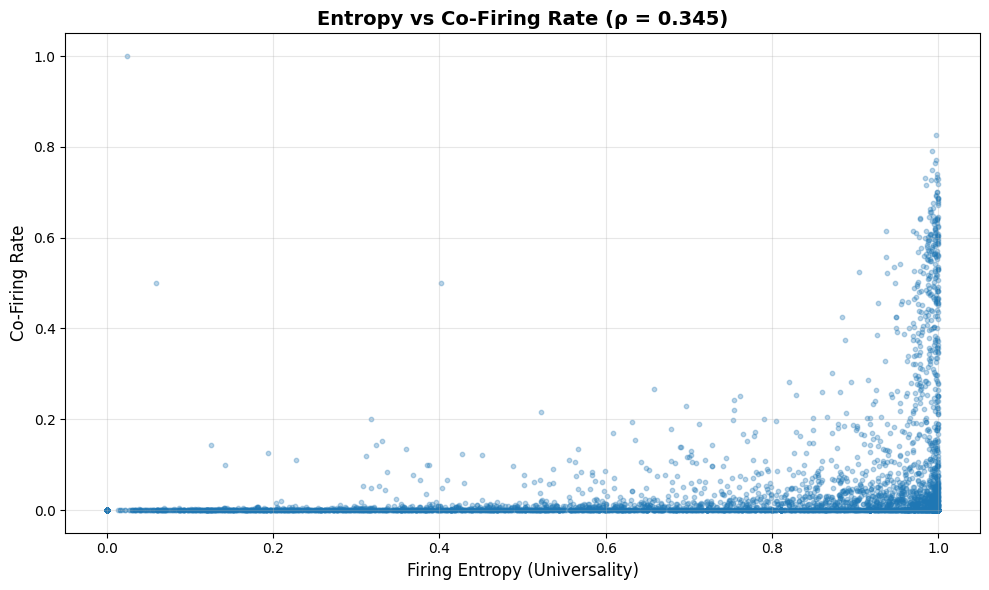


✅ Universality Analysis Complete!


In [19]:
# ==================== CORRELATION ANALYSIS ====================
print("\n" + "="*70)
print("ENTROPY vs CO-FIRING CORRELATION")
print("="*70)

# Get entropy and co-firing for active features only
active_indices = torch.where(active_features)[0]
active_entropy = entropy[active_features].cpu().numpy()
active_cofiring = cofiring_rate

# Compute correlation
correlation = np.corrcoef(active_entropy, active_cofiring)[0, 1]
print(f"Pearson correlation: {correlation:.4f}")

if correlation > 0.5:
    print("✅ STRONG positive correlation: Universal features (high entropy) tend to co-fire more!")
elif correlation > 0.3:
    print("✅ MODERATE positive correlation: Some relationship between universality and co-firing.")
else:
    print("⚠️  WEAK correlation: Universality and co-firing are somewhat independent.")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(active_entropy, active_cofiring, alpha=0.3, s=10)
plt.xlabel("Firing Entropy (Universality)", fontsize=12)
plt.ylabel("Co-Firing Rate", fontsize=12)
plt.title(f"Entropy vs Co-Firing Rate (ρ = {correlation:.3f})",
          fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('entropy_vs_cofiring.png', dpi=150)
plt.show()

print("\n✅ Universality Analysis Complete!")

# VISUALISING CONSENSUS

In [20]:
# ==================== COORDINATED ACTIVATION MAXIMIZATION (CAM) ====================
print("\n" + "="*70)
print("COORDINATED ACTIVATION MAXIMIZATION (CAM)")
print("="*70)

import torchvision.transforms as T

# Set models to eval mode
model_resnet.eval()
model_vit.eval()
for sae in saes.values():
    sae.eval()


def visualize_robust(feature_idx, model_name, lr=0.1, steps=300):
    """
    Optimize an image to maximize activation of a specific feature.

    Args:
        feature_idx: Index of feature to maximize
        model_name: 'resnet' or 'vit'
        lr: Learning rate
        steps: Number of optimization steps

    Returns:
        Optimized image tensor
    """
    # Initialize with small noise (not pure random)
    img = (torch.randn(1, 3, 224, 224, device=DEVICE) * 0.1).requires_grad_(True)
    optimizer = optim.Adam([img], lr=lr)

    # Select correct model and stats
    if model_name == 'resnet':
        model = model_resnet
        mean_stat = RES_MEAN
        std_stat = RES_STD
    else:
        model = model_vit
        mean_stat = VIT_MEAN
        std_stat = VIT_STD

    for i in range(steps):
        optimizer.zero_grad()

        # Forward pass through vision model
        model(img)

        # Normalize activation
        act = (activations[model_name] - mean_stat) / (std_stat + 1e-6)

        # ✅ CHANGED: Use saes[model_name] and unpack both returns
        z_pre, z = saes[model_name].encode(act)

        # Maximize specific feature (negative loss)
        loss = -z[0, feature_idx]

        loss.backward()
        optimizer.step()

        # Regularization: Blur every few steps to reduce noise
        if i % 2 == 0:
            with torch.no_grad():
                img.data = T.GaussianBlur(3, sigma=0.5)(img.data)

                # Optional: Keep pixel values in reasonable range
                img.data = torch.clamp(img.data, -3, 3)

    return img.detach()


def show_tensor(t, ax, title=""):
    """Display tensor as image with proper normalization"""
    t = t.squeeze().permute(1, 2, 0).cpu().numpy()

    # Robust normalization for display
    t = (t - t.mean()) / (t.std() + 1e-5) * 0.2 + 0.5
    t = np.clip(t, 0, 1)

    ax.imshow(t)
    ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold')


COORDINATED ACTIVATION MAXIMIZATION (CAM)


In [21]:
# ==================== SELECT FEATURES TO VISUALIZE ====================
print("\nSelecting features for visualization...")

# Calculate firing frequency
firing_freq = feature_activations.sum(1)  # Total fires across both models

# High entropy features (universal)
high_entropy_mask = entropy > 0.8
high_freq_mask = firing_freq > firing_freq.median()

# Get universal AND active features
good_features = torch.where(high_entropy_mask & high_freq_mask)[0]

print(f"✅ Found {len(good_features)} good universal features")

if len(good_features) < 3:
    print("⚠️  Not enough universal features, lowering entropy threshold...")
    high_entropy_mask = entropy > 0.6
    good_features = torch.where(high_entropy_mask & high_freq_mask)[0]
    print(f"✅ Found {len(good_features)} features with entropy > 0.6")

# Select 3 features to visualize
if len(good_features) >= 3:
    # Sort by firing frequency and pick top 3
    sorted_indices = good_features[firing_freq[good_features].argsort(descending=True)]
    selected_features = sorted_indices[:3].cpu().numpy()
else:
    print("❌ Not enough features to visualize! Using top entropy features instead...")
    selected_features = entropy.argsort(descending=True)[:3].cpu().numpy()

print(f"\nSelected features for CAM:")
for i, feat_idx in enumerate(selected_features):
    print(f"  Feature {i+1}: idx={feat_idx}, "
          f"entropy={entropy[feat_idx]:.3f}, "
          f"firing_freq={firing_freq[feat_idx].item():.0f}")


Selecting features for visualization...
✅ Found 1128 good universal features

Selected features for CAM:
  Feature 1: idx=214, entropy=0.992, firing_freq=26094
  Feature 2: idx=775, entropy=1.000, firing_freq=23152
  Feature 3: idx=667, entropy=1.000, firing_freq=22560



VISUALIZING UNIVERSAL FEATURES

Optimizing Feature 214...
  Entropy: 0.992
  Firing Frequency: 26094
  Optimizing for ResNet...
  Optimizing for ViT...

Optimizing Feature 775...
  Entropy: 1.000
  Firing Frequency: 23152
  Optimizing for ResNet...
  Optimizing for ViT...

Optimizing Feature 667...
  Entropy: 1.000
  Firing Frequency: 22560
  Optimizing for ResNet...
  Optimizing for ViT...


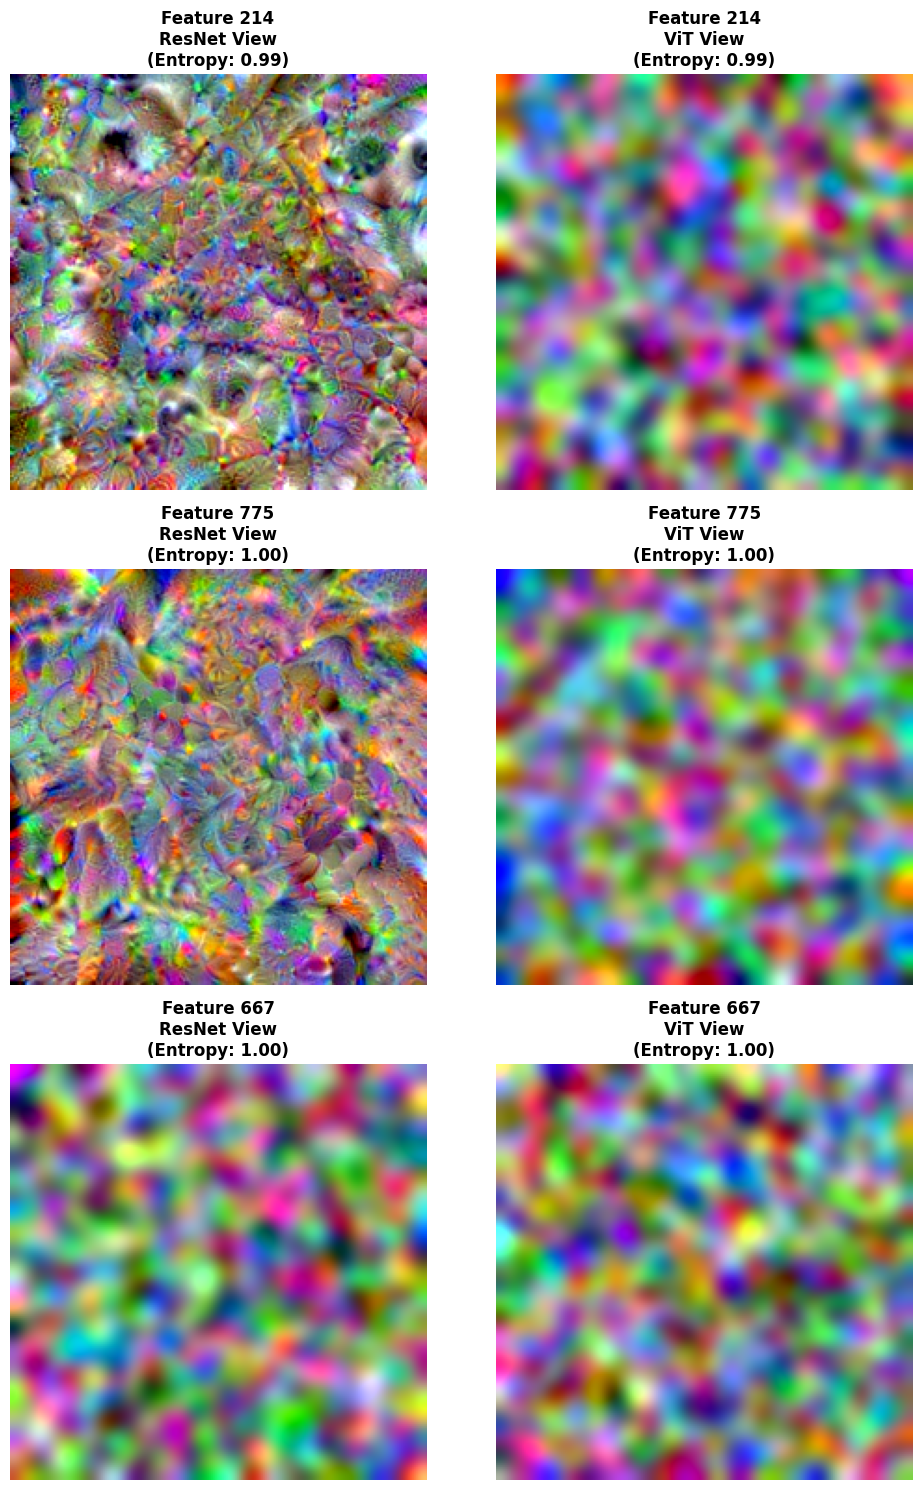


✅ Universal feature visualization complete!


In [22]:
# ==================== VISUALIZE 3 UNIVERSAL FEATURES ====================
print("\n" + "="*70)
print("VISUALIZING UNIVERSAL FEATURES")
print("="*70)

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

for row, feature_idx in enumerate(selected_features):
    print(f"\nOptimizing Feature {feature_idx}...")
    print(f"  Entropy: {entropy[feature_idx]:.3f}")
    print(f"  Firing Frequency: {firing_freq[feature_idx].item():.0f}")

    # Optimize for ResNet
    print("  Optimizing for ResNet...")
    img_resnet = visualize_robust(feature_idx, 'resnet', lr=0.1, steps=300)

    # Optimize for ViT
    print("  Optimizing for ViT...")
    img_vit = visualize_robust(feature_idx, 'vit', lr=0.1, steps=300)

    # Display
    show_tensor(img_resnet, axes[row, 0],
                f"Feature {feature_idx}\nResNet View\n(Entropy: {entropy[feature_idx]:.2f})")
    show_tensor(img_vit, axes[row, 1],
                f"Feature {feature_idx}\nViT View\n(Entropy: {entropy[feature_idx]:.2f})")

plt.tight_layout()
plt.savefig('cam_universal_features.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Universal feature visualization complete!")


FINDING DIVERGENT FEATURE (High Entropy but Different Visuals)

Selected divergent feature: 2050
  Entropy: 0.999
  Firing Frequency: 12933
  ResNet fires: 6257
  ViT fires: 6676

Optimizing divergent feature...


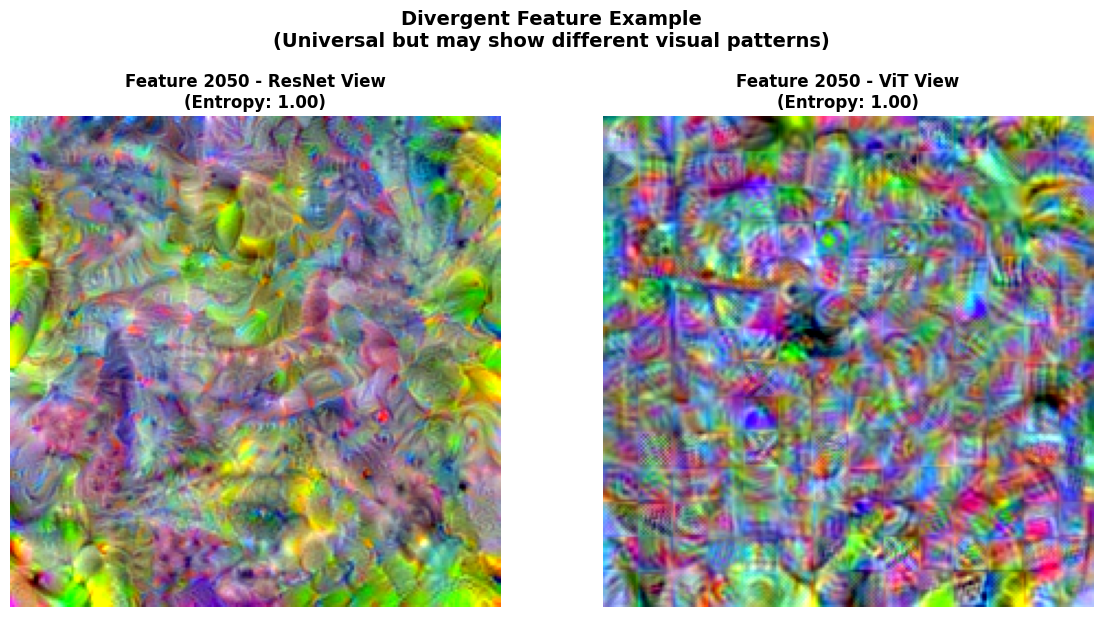

In [23]:
# ==================== FIND DIVERGENT FEATURE ====================
print("\n" + "="*70)
print("FINDING DIVERGENT FEATURE (High Entropy but Different Visuals)")
print("="*70)

# We want features with high entropy but might look different
# These are features that fire frequently but might represent different aspects

# Try to find features that fire more in one model than the other
model_balance = feature_activations[:, 0] / (feature_activations.sum(1) + 1e-8)
# model_balance close to 0.5 = balanced, far from 0.5 = imbalanced

balanced_mask = (model_balance > 0.4) & (model_balance < 0.6)
universal_balanced = torch.where(high_entropy_mask & balanced_mask & (firing_freq > firing_freq.median()))[0]

if len(universal_balanced) > 0:
    # Pick one from the middle (not the most universal, not the least)
    divergent_idx = universal_balanced[len(universal_balanced) // 2].item()
else:
    # Fallback: pick a universal feature
    divergent_idx = good_features[len(good_features) // 2].item()

print(f"\nSelected divergent feature: {divergent_idx}")
print(f"  Entropy: {entropy[divergent_idx]:.3f}")
print(f"  Firing Frequency: {firing_freq[divergent_idx].item():.0f}")
print(f"  ResNet fires: {feature_activations[divergent_idx, 0].item():.0f}")
print(f"  ViT fires: {feature_activations[divergent_idx, 1].item():.0f}")

# Visualize divergent feature
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

print("\nOptimizing divergent feature...")
img_resnet_div = visualize_robust(divergent_idx, 'resnet', lr=0.1, steps=400)
img_vit_div = visualize_robust(divergent_idx, 'vit', lr=0.1, steps=400)

show_tensor(img_resnet_div, axes[0],
            f"Feature {divergent_idx} - ResNet View\n(Entropy: {entropy[divergent_idx]:.2f})")
show_tensor(img_vit_div, axes[1],
            f"Feature {divergent_idx} - ViT View\n(Entropy: {entropy[divergent_idx]:.2f})")

plt.suptitle("Divergent Feature Example\n(Universal but may show different visual patterns)",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('cam_divergent_feature.png', dpi=150, bbox_inches='tight')
plt.show()


BONUS: Visualizing Top 6 Universal Features
Visualizing feature 214...
Visualizing feature 775...
Visualizing feature 667...
Visualizing feature 3446...
Visualizing feature 2717...
Visualizing feature 811...


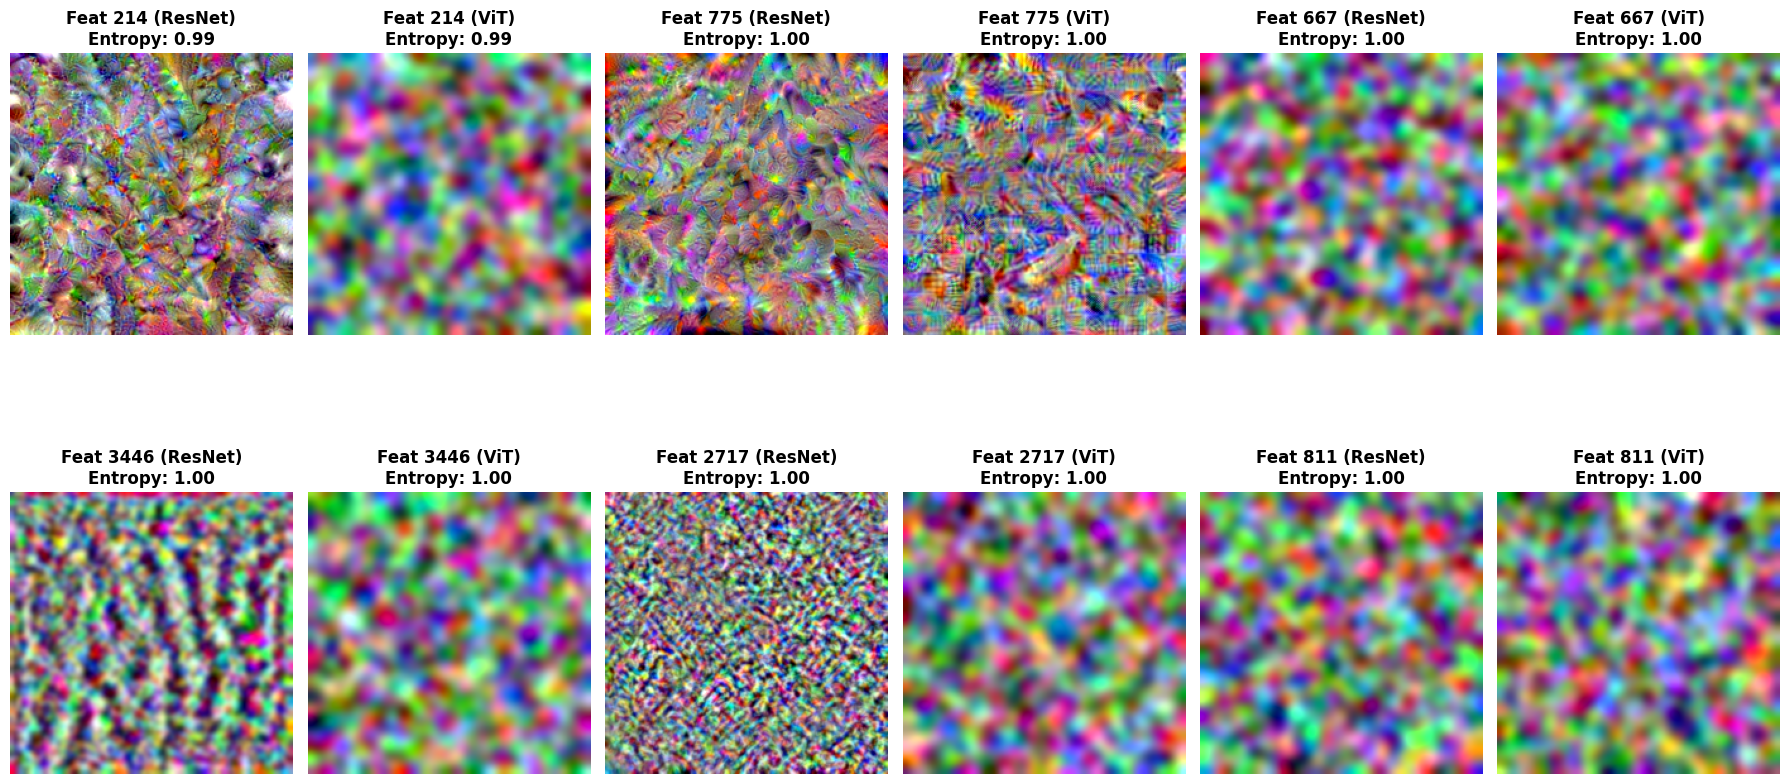

In [24]:
# ==================== OPTIONAL: VISUALIZE MORE FEATURES ====================
def visualize_feature_grid(feature_indices, rows=2, cols=3, steps=300):
    """
    Visualize multiple features in a grid.

    Args:
        feature_indices: List of feature indices
        rows, cols: Grid dimensions
        steps: Optimization steps per feature
    """
    n_features = len(feature_indices)
    assert n_features <= rows * cols, "Too many features for grid"

    fig, axes = plt.subplots(rows, cols * 2, figsize=(cols * 6, rows * 5))

    for i, feat_idx in enumerate(feature_indices):
        row = i // cols
        col_pair = (i % cols) * 2

        print(f"Visualizing feature {feat_idx}...")

        # Optimize
        img_res = visualize_robust(feat_idx, 'resnet', lr=0.1, steps=steps)
        img_vit = visualize_robust(feat_idx, 'vit', lr=0.1, steps=steps)

        # Display
        show_tensor(img_res, axes[row, col_pair],
                   f"Feat {feat_idx} (ResNet)\nEntropy: {entropy[feat_idx]:.2f}")
        show_tensor(img_vit, axes[row, col_pair + 1],
                   f"Feat {feat_idx} (ViT)\nEntropy: {entropy[feat_idx]:.2f}")

    # Hide unused subplots
    for i in range(n_features, rows * cols):
        row = i // cols
        col_pair = (i % cols) * 2
        axes[row, col_pair].axis('off')
        axes[row, col_pair + 1].axis('off')

    plt.tight_layout()
    plt.savefig('cam_feature_grid.png', dpi=150, bbox_inches='tight')
    plt.show()


# Example: Visualize top 6 universal features
if len(good_features) >= 6:
    print("\n" + "="*70)
    print("BONUS: Visualizing Top 6 Universal Features")
    print("="*70)

    top_6_features = good_features[firing_freq[good_features].argsort(descending=True)][:6].cpu().numpy()
    visualize_feature_grid(top_6_features, rows=2, cols=3, steps=250)

# Independent SAE

In [25]:
# ==================== ALIGNMENT TAX & ANALYSIS ====================
print("\n" + "="*70)
print("PART 4: ALIGNMENT TAX & COMPREHENSIVE ANALYSIS")
print("="*70)

# ==================== TRAIN INDEPENDENT SAEs ====================
print("\nTraining Independent SAEs for comparison...")

# We'll use TopKSAE from overcomplete for fair comparison
from overcomplete.sae import TopKSAE

# Initialize Independent SAEs (same architecture as USAE)
independent_sae_resnet = TopKSAE(
    input_shape=D_RESNET,
    nb_concepts=DICT_SIZE,
    top_k=K,
    device=DEVICE
)

independent_sae_vit = TopKSAE(
    input_shape=D_VIT,
    nb_concepts=DICT_SIZE,
    top_k=K,
    device=DEVICE
)

optimizer_resnet = optim.Adam(independent_sae_resnet.parameters(), lr=LR)
optimizer_vit = optim.Adam(independent_sae_vit.parameters(), lr=LR)

scheduler_resnet = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_resnet, T_max=EPOCHS * len(loader), eta_min=1e-6
)
scheduler_vit = optim.lr_scheduler.CosineAnnealingLR(
    optimizer_vit, T_max=EPOCHS * len(loader), eta_min=1e-6
)

# Loss criterion (MSE to match USAE)
def independent_criterion(x, x_hat, pre_codes, codes, dictionary):
    return (x - x_hat).square().mean()




PART 4: ALIGNMENT TAX & COMPREHENSIVE ANALYSIS

Training Independent SAEs for comparison...


In [26]:
# Training ResNet SAE
print("\nTraining Independent SAE for ResNet...")
ind_loss_history_resnet = []
ind_r2_resnet_epoch = []

independent_sae_resnet.train()
for epoch in range(EPOCHS):
    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS} [ResNet SAE]")
    epoch_losses = []
    epoch_r2s = []

    for imgs, _ in loop:
        imgs = imgs.to(DEVICE)

        with torch.no_grad():
            model_resnet(imgs)
            act_resnet = (activations['resnet'] - RES_MEAN) / (RES_STD + 1e-6)

        # Forward pass
        z_pre, z = independent_sae_resnet.encode(act_resnet)
        recon_resnet = independent_sae_resnet.decode(z)

        # Loss (MSE to match USAE)
        loss = independent_criterion(
            act_resnet, recon_resnet, z_pre, z,
            independent_sae_resnet.get_dictionary()
        )

        # Backprop
        optimizer_resnet.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(independent_sae_resnet.parameters(), max_norm=1.0)
        optimizer_resnet.step()
        scheduler_resnet.step()

        # Metrics
        epoch_losses.append(loss.item())
        with torch.no_grad():
            r2 = r2_score(act_resnet, recon_resnet).item()
            epoch_r2s.append(r2)

        loop.set_postfix(loss=loss.item(), r2=r2)

    ind_loss_history_resnet.extend(epoch_losses)
    ind_r2_resnet_epoch.append(np.mean(epoch_r2s))
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Loss: {np.mean(epoch_losses):.4f}, Avg R²: {np.mean(epoch_r2s):.4f}")




Training Independent SAE for ResNet...


Epoch 1/25 [ResNet SAE]: 100%|██████████| 390/390 [01:29<00:00,  4.37it/s, loss=0.471, r2=0.519]


Epoch 1/25 - Avg Loss: 0.6806, Avg R²: 0.3188


Epoch 2/25 [ResNet SAE]: 100%|██████████| 390/390 [01:30<00:00,  4.32it/s, loss=0.383, r2=0.602]


Epoch 2/25 - Avg Loss: 0.4199, Avg R²: 0.5796


Epoch 3/25 [ResNet SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.51it/s, loss=0.368, r2=0.645]


Epoch 3/25 - Avg Loss: 0.3684, Avg R²: 0.6312


Epoch 4/25 [ResNet SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.47it/s, loss=0.344, r2=0.654]


Epoch 4/25 - Avg Loss: 0.3459, Avg R²: 0.6536


Epoch 5/25 [ResNet SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.48it/s, loss=0.329, r2=0.68]


Epoch 5/25 - Avg Loss: 0.3325, Avg R²: 0.6671


Epoch 6/25 [ResNet SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.53it/s, loss=0.327, r2=0.68]


Epoch 6/25 - Avg Loss: 0.3229, Avg R²: 0.6767


Epoch 7/25 [ResNet SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.44it/s, loss=0.328, r2=0.676]


Epoch 7/25 - Avg Loss: 0.3153, Avg R²: 0.6844


Epoch 8/25 [ResNet SAE]: 100%|██████████| 390/390 [01:29<00:00,  4.38it/s, loss=0.299, r2=0.691]


Epoch 8/25 - Avg Loss: 0.3089, Avg R²: 0.6907


Epoch 9/25 [ResNet SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.45it/s, loss=0.31, r2=0.681]


Epoch 9/25 - Avg Loss: 0.3032, Avg R²: 0.6964


Epoch 10/25 [ResNet SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.42it/s, loss=0.3, r2=0.698]


Epoch 10/25 - Avg Loss: 0.2979, Avg R²: 0.7017


Epoch 11/25 [ResNet SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.39it/s, loss=0.293, r2=0.709]


Epoch 11/25 - Avg Loss: 0.2932, Avg R²: 0.7065


Epoch 12/25 [ResNet SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.43it/s, loss=0.289, r2=0.704]


Epoch 12/25 - Avg Loss: 0.2887, Avg R²: 0.7109


Epoch 13/25 [ResNet SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.40it/s, loss=0.28, r2=0.71]


Epoch 13/25 - Avg Loss: 0.2847, Avg R²: 0.7150


Epoch 14/25 [ResNet SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.38it/s, loss=0.284, r2=0.723]


Epoch 14/25 - Avg Loss: 0.2810, Avg R²: 0.7186


Epoch 15/25 [ResNet SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.40it/s, loss=0.273, r2=0.713]


Epoch 15/25 - Avg Loss: 0.2776, Avg R²: 0.7221


Epoch 16/25 [ResNet SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.45it/s, loss=0.262, r2=0.723]


Epoch 16/25 - Avg Loss: 0.2746, Avg R²: 0.7250


Epoch 17/25 [ResNet SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.40it/s, loss=0.272, r2=0.724]


Epoch 17/25 - Avg Loss: 0.2721, Avg R²: 0.7275


Epoch 18/25 [ResNet SAE]: 100%|██████████| 390/390 [01:29<00:00,  4.35it/s, loss=0.276, r2=0.728]


Epoch 18/25 - Avg Loss: 0.2699, Avg R²: 0.7297


Epoch 19/25 [ResNet SAE]: 100%|██████████| 390/390 [01:29<00:00,  4.37it/s, loss=0.26, r2=0.723]


Epoch 19/25 - Avg Loss: 0.2681, Avg R²: 0.7315


Epoch 20/25 [ResNet SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.51it/s, loss=0.263, r2=0.737]


Epoch 20/25 - Avg Loss: 0.2667, Avg R²: 0.7330


Epoch 21/25 [ResNet SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.40it/s, loss=0.272, r2=0.728]


Epoch 21/25 - Avg Loss: 0.2655, Avg R²: 0.7341


Epoch 22/25 [ResNet SAE]: 100%|██████████| 390/390 [01:25<00:00,  4.54it/s, loss=0.264, r2=0.729]


Epoch 22/25 - Avg Loss: 0.2647, Avg R²: 0.7349


Epoch 23/25 [ResNet SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.52it/s, loss=0.274, r2=0.731]


Epoch 23/25 - Avg Loss: 0.2641, Avg R²: 0.7356


Epoch 24/25 [ResNet SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.41it/s, loss=0.258, r2=0.741]


Epoch 24/25 - Avg Loss: 0.2637, Avg R²: 0.7360


Epoch 25/25 [ResNet SAE]: 100%|██████████| 390/390 [01:25<00:00,  4.58it/s, loss=0.266, r2=0.742]

Epoch 25/25 - Avg Loss: 0.2634, Avg R²: 0.7362


In [27]:
# Training ViT SAE
print("\nTraining Independent SAE for ViT...")
ind_loss_history_vit = []
ind_r2_vit_epoch = []

independent_sae_vit.train()
for epoch in range(EPOCHS):
    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS} [ViT SAE]")
    epoch_losses = []
    epoch_r2s = []

    for imgs, _ in loop:
        imgs = imgs.to(DEVICE)

        with torch.no_grad():
            model_vit(imgs)
            act_vit = (activations['vit'] - VIT_MEAN) / (VIT_STD + 1e-6)

        # Forward pass
        z_pre, z = independent_sae_vit.encode(act_vit)
        recon_vit = independent_sae_vit.decode(z)

        # Loss
        loss = independent_criterion(
            act_vit, recon_vit, z_pre, z,
            independent_sae_vit.get_dictionary()
        )

        # Backprop
        optimizer_vit.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(independent_sae_vit.parameters(), max_norm=1.0)
        optimizer_vit.step()
        scheduler_vit.step()

        # Metrics
        epoch_losses.append(loss.item())
        with torch.no_grad():
            r2 = r2_score(act_vit, recon_vit).item()
            epoch_r2s.append(r2)

        loop.set_postfix(loss=loss.item(), r2=r2)

    ind_loss_history_vit.extend(epoch_losses)
    ind_r2_vit_epoch.append(np.mean(epoch_r2s))
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Loss: {np.mean(epoch_losses):.4f}, Avg R²: {np.mean(epoch_r2s):.4f}")

print("\n✅ Independent SAE training complete!")


Training Independent SAE for ViT...


Epoch 1/25 [ViT SAE]: 100%|██████████| 390/390 [01:29<00:00,  4.38it/s, loss=0.553, r2=0.454]


Epoch 1/25 - Avg Loss: 0.8120, Avg R²: 0.1889


Epoch 2/25 [ViT SAE]: 100%|██████████| 390/390 [01:30<00:00,  4.29it/s, loss=0.354, r2=0.638]


Epoch 2/25 - Avg Loss: 0.4234, Avg R²: 0.5771


Epoch 3/25 [ViT SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.46it/s, loss=0.31, r2=0.685]


Epoch 3/25 - Avg Loss: 0.3303, Avg R²: 0.6700


Epoch 4/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.49it/s, loss=0.278, r2=0.713]


Epoch 4/25 - Avg Loss: 0.2920, Avg R²: 0.7082


Epoch 5/25 [ViT SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.38it/s, loss=0.247, r2=0.737]


Epoch 5/25 - Avg Loss: 0.2716, Avg R²: 0.7287


Epoch 6/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.50it/s, loss=0.236, r2=0.748]


Epoch 6/25 - Avg Loss: 0.2582, Avg R²: 0.7420


Epoch 7/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.52it/s, loss=0.247, r2=0.756]


Epoch 7/25 - Avg Loss: 0.2482, Avg R²: 0.7520


Epoch 8/25 [ViT SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.45it/s, loss=0.24, r2=0.761]


Epoch 8/25 - Avg Loss: 0.2403, Avg R²: 0.7599


Epoch 9/25 [ViT SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.43it/s, loss=0.229, r2=0.767]


Epoch 9/25 - Avg Loss: 0.2334, Avg R²: 0.7667


Epoch 10/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.48it/s, loss=0.236, r2=0.769]


Epoch 10/25 - Avg Loss: 0.2275, Avg R²: 0.7726


Epoch 11/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.53it/s, loss=0.226, r2=0.77]


Epoch 11/25 - Avg Loss: 0.2223, Avg R²: 0.7778


Epoch 12/25 [ViT SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.44it/s, loss=0.229, r2=0.782]


Epoch 12/25 - Avg Loss: 0.2177, Avg R²: 0.7825


Epoch 13/25 [ViT SAE]: 100%|██████████| 390/390 [01:25<00:00,  4.54it/s, loss=0.222, r2=0.786]


Epoch 13/25 - Avg Loss: 0.2135, Avg R²: 0.7866


Epoch 14/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.49it/s, loss=0.22, r2=0.781]


Epoch 14/25 - Avg Loss: 0.2099, Avg R²: 0.7903


Epoch 15/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.50it/s, loss=0.206, r2=0.797]


Epoch 15/25 - Avg Loss: 0.2067, Avg R²: 0.7935


Epoch 16/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.51it/s, loss=0.199, r2=0.799]


Epoch 16/25 - Avg Loss: 0.2039, Avg R²: 0.7963


Epoch 17/25 [ViT SAE]: 100%|██████████| 390/390 [01:29<00:00,  4.38it/s, loss=0.197, r2=0.797]


Epoch 17/25 - Avg Loss: 0.2015, Avg R²: 0.7987


Epoch 18/25 [ViT SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.42it/s, loss=0.182, r2=0.806]


Epoch 18/25 - Avg Loss: 0.1994, Avg R²: 0.8008


Epoch 19/25 [ViT SAE]: 100%|██████████| 390/390 [01:25<00:00,  4.54it/s, loss=0.195, r2=0.803]


Epoch 19/25 - Avg Loss: 0.1978, Avg R²: 0.8024


Epoch 20/25 [ViT SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.45it/s, loss=0.199, r2=0.804]


Epoch 20/25 - Avg Loss: 0.1964, Avg R²: 0.8037


Epoch 21/25 [ViT SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.39it/s, loss=0.194, r2=0.808]


Epoch 21/25 - Avg Loss: 0.1953, Avg R²: 0.8048


Epoch 22/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.51it/s, loss=0.198, r2=0.809]


Epoch 22/25 - Avg Loss: 0.1945, Avg R²: 0.8057


Epoch 23/25 [ViT SAE]: 100%|██████████| 390/390 [01:27<00:00,  4.45it/s, loss=0.19, r2=0.809]


Epoch 23/25 - Avg Loss: 0.1938, Avg R²: 0.8063


Epoch 24/25 [ViT SAE]: 100%|██████████| 390/390 [01:28<00:00,  4.40it/s, loss=0.19, r2=0.808]


Epoch 24/25 - Avg Loss: 0.1935, Avg R²: 0.8067


Epoch 25/25 [ViT SAE]: 100%|██████████| 390/390 [01:26<00:00,  4.51it/s, loss=0.185, r2=0.803]

Epoch 25/25 - Avg Loss: 0.1932, Avg R²: 0.8070

✅ Independent SAE training complete!


In [28]:
# ==================== COMPUTE FINAL R² SCORES ====================
print("\n" + "="*70)
print("COMPUTING FINAL R² SCORES")
print("="*70)

# USAE self-reconstruction R²
usae_r2_resnet = []
usae_r2_vit = []

for sae in saes.values():
    sae.eval()

with torch.no_grad():
    for imgs, _ in tqdm(loader, desc="Computing USAE R²"):
        imgs = imgs.to(DEVICE)

        model_resnet(imgs)
        model_vit(imgs)

        acts = {
            'resnet': (activations['resnet'] - RES_MEAN) / (RES_STD + 1e-6),
            'vit': (activations['vit'] - VIT_MEAN) / (VIT_STD + 1e-6)
        }

        # ResNet self-reconstruction
        z_pre_res, z_res = saes['resnet'].encode(acts['resnet'])
        recon_res = saes['resnet'].decode(z_res)
        usae_r2_resnet.append(r2_score(acts['resnet'], recon_res).item())

        # ViT self-reconstruction
        z_pre_vit, z_vit = saes['vit'].encode(acts['vit'])
        recon_vit = saes['vit'].decode(z_vit)
        usae_r2_vit.append(r2_score(acts['vit'], recon_vit).item())

# Independent SAE R²
ind_sae_r2_resnet = []
ind_sae_r2_vit = []

independent_sae_resnet.eval()
independent_sae_vit.eval()

with torch.no_grad():
    for imgs, _ in tqdm(loader, desc="Computing Independent SAE R²"):
        imgs = imgs.to(DEVICE)

        model_resnet(imgs)
        model_vit(imgs)

        acts = {
            'resnet': (activations['resnet'] - RES_MEAN) / (RES_STD + 1e-6),
            'vit': (activations['vit'] - VIT_MEAN) / (VIT_STD + 1e-6)
        }

        # ResNet Independent SAE
        z_pre_res, z_res = independent_sae_resnet.encode(acts['resnet'])
        recon_res = independent_sae_resnet.decode(z_res)
        ind_sae_r2_resnet.append(r2_score(acts['resnet'], recon_res).item())

        # ViT Independent SAE
        z_pre_vit, z_vit = independent_sae_vit.encode(acts['vit'])
        recon_vit = independent_sae_vit.decode(z_vit)
        ind_sae_r2_vit.append(r2_score(acts['vit'], recon_vit).item())


COMPUTING FINAL R² SCORES


Computing Independent SAE R²: 100%|██████████| 390/390 [01:40<00:00,  3.89it/s]


In [29]:
# ==================== ALIGNMENT TAX ANALYSIS ====================
print("\n" + "="*70)
print("ALIGNMENT TAX ANALYSIS")
print("="*70)

usae_r2_resnet_mean = np.mean(usae_r2_resnet)
usae_r2_vit_mean = np.mean(usae_r2_vit)
ind_r2_resnet_mean = np.mean(ind_sae_r2_resnet)
ind_r2_vit_mean = np.mean(ind_sae_r2_vit)

print(f"\nSelf-Reconstruction R² Scores:")
print(f"{'Model':<15} {'USAE R²':<15} {'Independent R²':<20} {'Alignment Tax':<15}")
print("-" * 75)
print(f"{'ResNet':<15} {usae_r2_resnet_mean:<15.4f} {ind_r2_resnet_mean:<20.4f} {ind_r2_resnet_mean - usae_r2_resnet_mean:<15.4f}")
print(f"{'ViT':<15} {usae_r2_vit_mean:<15.4f} {ind_r2_vit_mean:<20.4f} {ind_r2_vit_mean - usae_r2_vit_mean:<15.4f}")
print(f"{'Average':<15} {np.mean([usae_r2_resnet_mean, usae_r2_vit_mean]):<15.4f} {np.mean([ind_r2_resnet_mean, ind_r2_vit_mean]):<20.4f} {np.mean([ind_r2_resnet_mean - usae_r2_resnet_mean, ind_r2_vit_mean - usae_r2_vit_mean]):<15.4f}")

alignment_tax = np.mean([ind_r2_resnet_mean - usae_r2_resnet_mean,
                         ind_r2_vit_mean - usae_r2_vit_mean])

print(f"\n📊 Average Alignment Tax: {alignment_tax:.4f} ({alignment_tax*100:.2f}%)")

if alignment_tax > 0.05:
    print(f"⚠️  USAE pays a {alignment_tax*100:.2f}% alignment tax for universality")
    print("   Interpretation: Forcing features to be shared degrades self-reconstruction.")
    print("   Trade-off: Lower quality BUT gains cross-model interpretability.")
elif alignment_tax > 0:
    print(f"✅ Minimal alignment tax ({alignment_tax*100:.2f}%)")
    print("   Interpretation: Universality comes almost for free!")
else:
    print(f"✅ No alignment tax! USAE matches or exceeds independent performance.")
    print("   Interpretation: Shared bottleneck acts as regularization.")


ALIGNMENT TAX ANALYSIS

Self-Reconstruction R² Scores:
Model           USAE R²         Independent R²       Alignment Tax  
---------------------------------------------------------------------------
ResNet          0.6336          0.7364               0.1028         
ViT             0.7596          0.8071               0.0475         
Average         0.6966          0.7717               0.0751         

📊 Average Alignment Tax: 0.0751 (7.51%)
⚠️  USAE pays a 7.51% alignment tax for universality
   Interpretation: Forcing features to be shared degrades self-reconstruction.
   Trade-off: Lower quality BUT gains cross-model interpretability.


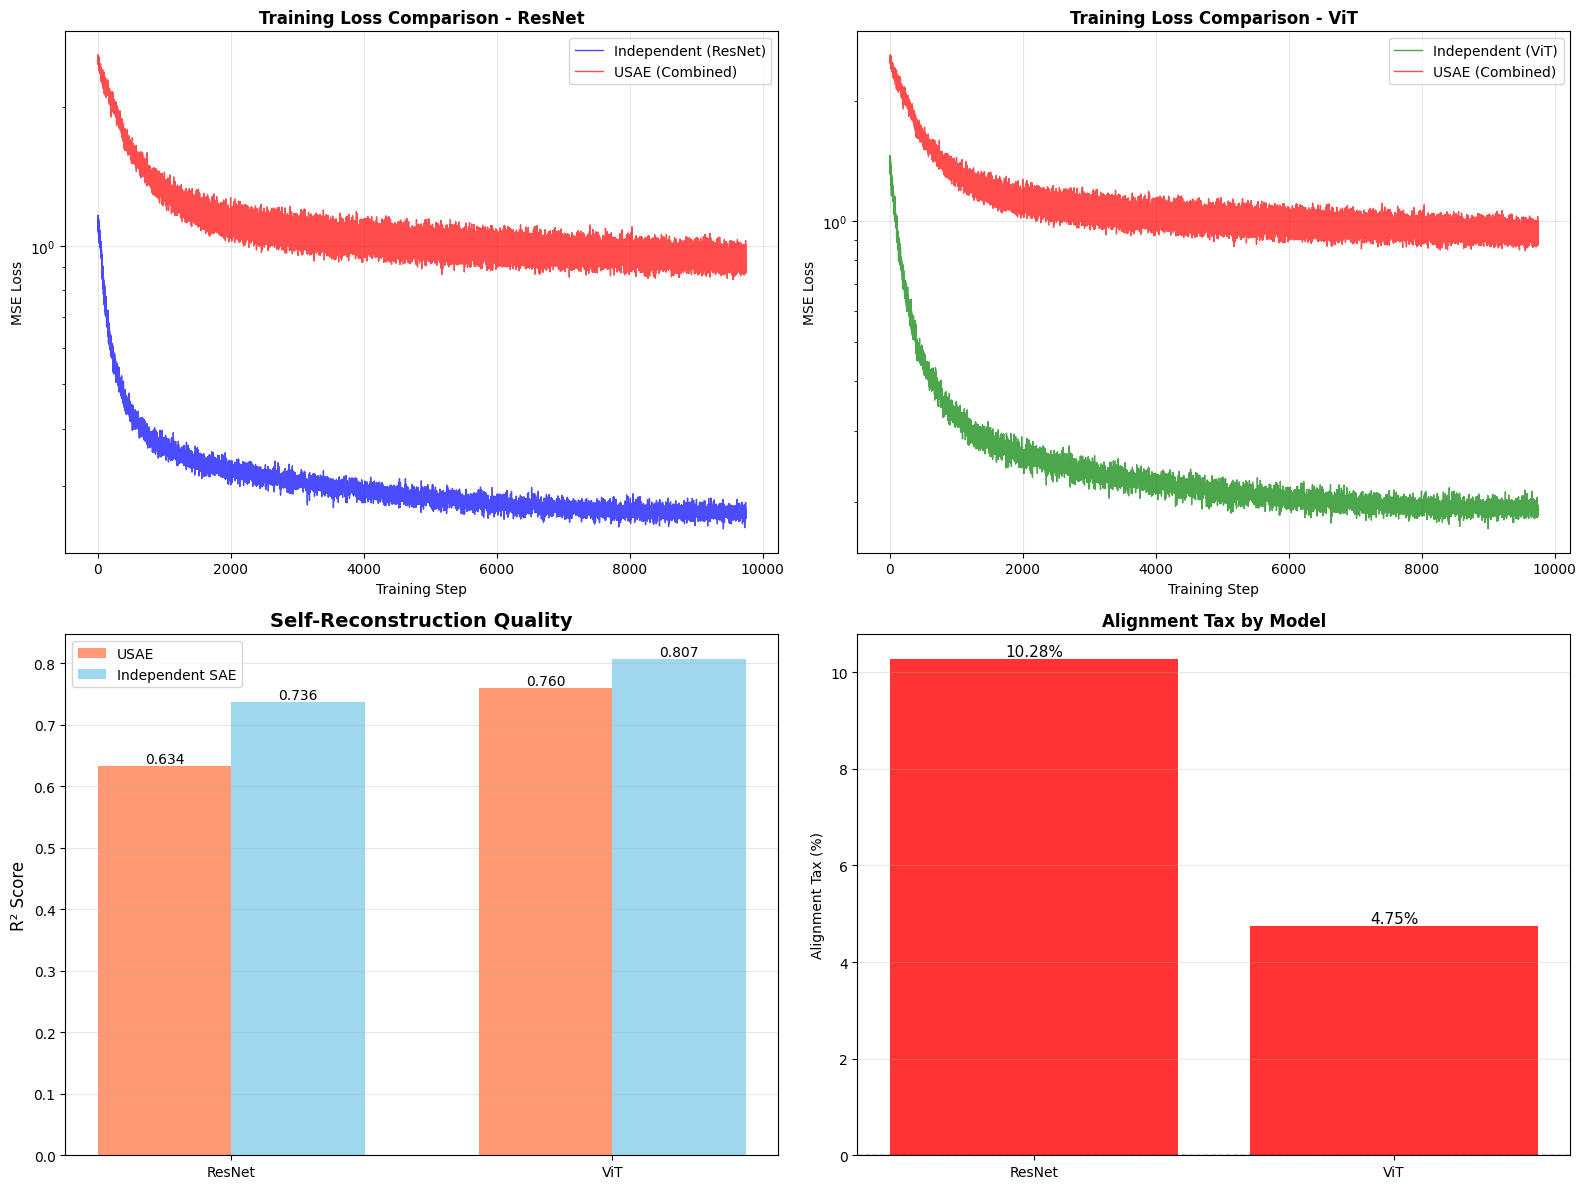

In [30]:
# ==================== VISUALIZATIONS ====================
# 1. Loss Curves Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training losses
axes[0, 0].plot(ind_loss_history_resnet, label='Independent (ResNet)', alpha=0.7, color='blue', linewidth=1)
axes[0, 0].plot(logs['step_loss'], label='USAE (Combined)', alpha=0.7, color='red', linewidth=1)
axes[0, 0].set_title('Training Loss Comparison - ResNet', fontweight='bold')
axes[0, 0].set_xlabel('Training Step')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_yscale('log')

axes[0, 1].plot(ind_loss_history_vit, label='Independent (ViT)', alpha=0.7, color='green', linewidth=1)
axes[0, 1].plot(logs['step_loss'], label='USAE (Combined)', alpha=0.7, color='red', linewidth=1)
axes[0, 1].set_title('Training Loss Comparison - ViT', fontweight='bold')
axes[0, 1].set_xlabel('Training Step')
axes[0, 1].set_ylabel('MSE Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_yscale('log')

# R² comparison bar chart
x = np.arange(2)
width = 0.35
usae_scores = [usae_r2_resnet_mean, usae_r2_vit_mean]
ind_scores = [ind_r2_resnet_mean, ind_r2_vit_mean]

bars1 = axes[1, 0].bar(x - width/2, usae_scores, width, label='USAE', color='coral', alpha=0.8)
bars2 = axes[1, 0].bar(x + width/2, ind_scores, width, label='Independent SAE', color='skyblue', alpha=0.8)
axes[1, 0].set_ylabel('R² Score', fontsize=12)
axes[1, 0].set_title('Self-Reconstruction Quality', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['ResNet', 'ViT'])
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=10)

# Alignment tax visualization
models = ['ResNet', 'ViT']
alignment_taxes = [ind_r2_resnet_mean - usae_r2_resnet_mean,
                   ind_r2_vit_mean - usae_r2_vit_mean]

colors = ['red' if tax > 0 else 'green' for tax in alignment_taxes]
axes[1, 1].bar(models, [tax * 100 for tax in alignment_taxes], alpha=0.8, color=colors)
axes[1, 1].set_ylabel('Alignment Tax (%)')
axes[1, 1].set_title('Alignment Tax by Model', fontweight='bold')
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].grid(alpha=0.3, axis='y')

for i, (model, tax) in enumerate(zip(models, alignment_taxes)):
    axes[1, 1].text(i, tax * 100, f'{tax*100:.2f}%',
                   ha='center', va='bottom' if tax > 0 else 'top', fontsize=11)

plt.tight_layout()
plt.savefig('alignment_tax_analysis.png', dpi=150)
plt.show()


ANALYZING MODEL-SPECIFIC FEATURES (Low Entropy)
Found 518 model-specific features (entropy < 0.2)
  ResNet-specific: 471
  ViT-specific: 47

Visualizing model-specific features...

Visualizing model-specific feature 17...

Visualizing model-specific feature 255...

Visualizing model-specific feature 24...


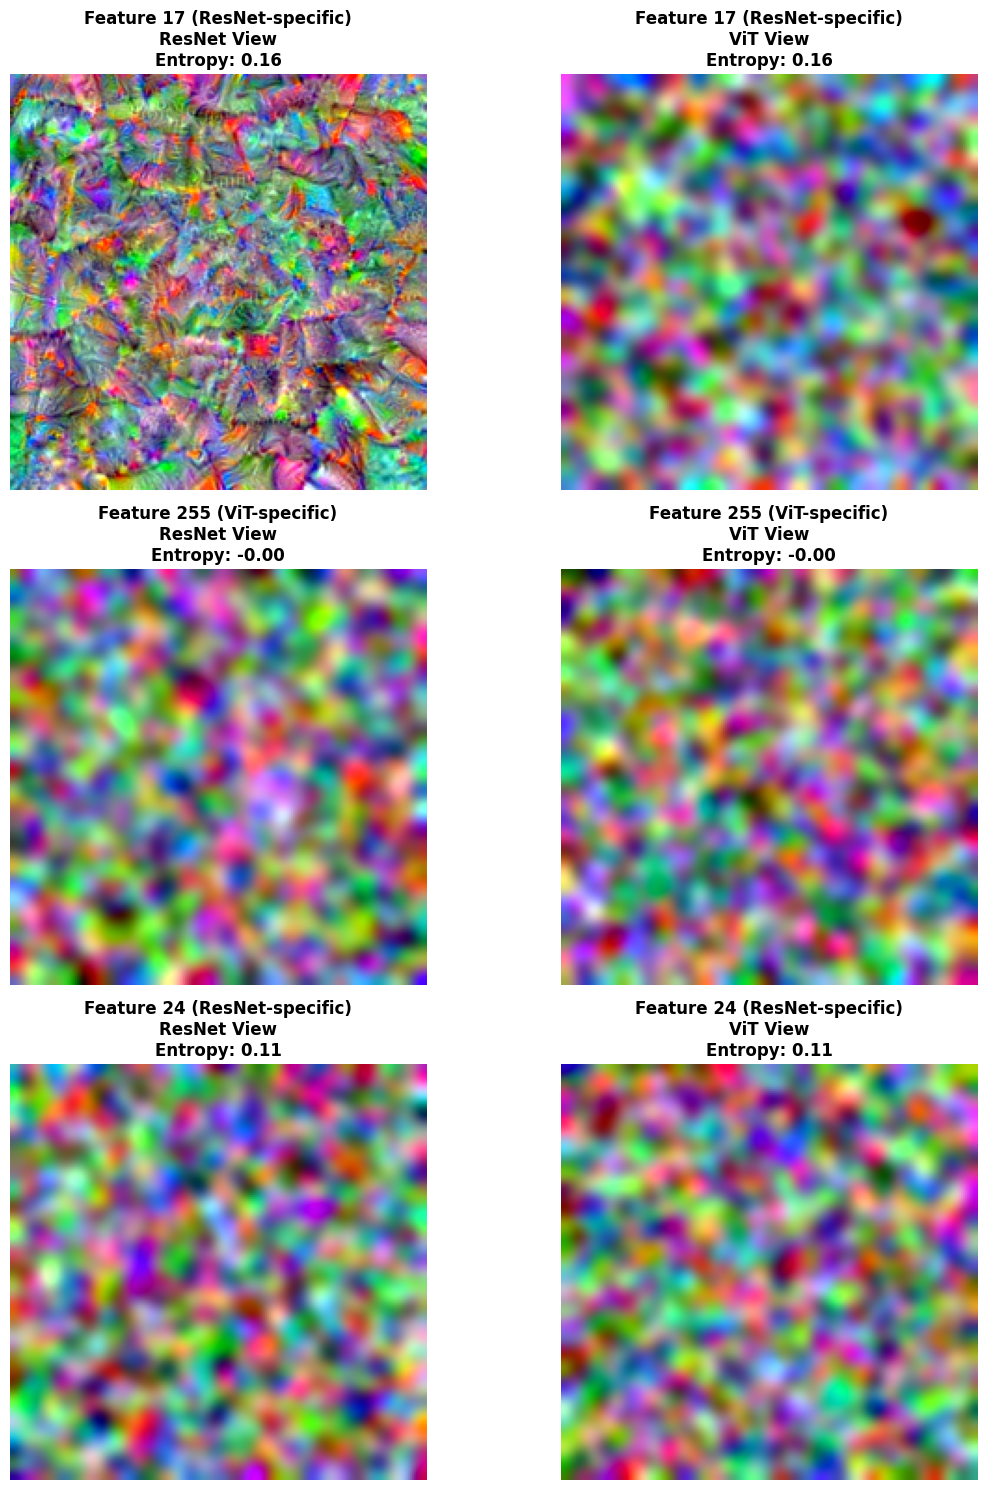


Interpretation:
- If the model-specific features show meaningful patterns:
  → They capture unique architectural biases (e.g., local textures for CNN)
- If they show noise/artifacts:
  → The other model correctly learned to ignore irrelevant patterns


In [31]:
# ==================== LOW ENTROPY FEATURES ANALYSIS ====================
print("\n" + "="*70)
print("ANALYZING MODEL-SPECIFIC FEATURES (Low Entropy)")
print("="*70)

# Find model-specific features
low_entropy_features = torch.where((entropy < 0.2) & active_features)[0]

print(f"Found {len(low_entropy_features)} model-specific features (entropy < 0.2)")

if len(low_entropy_features) > 0:
    # Determine which model each feature belongs to
    feature_model_assignment = []
    for feat_idx in low_entropy_features:
        res_fires = feature_activations[feat_idx, 0].item()
        vit_fires = feature_activations[feat_idx, 1].item()

        if res_fires > vit_fires:
            feature_model_assignment.append('resnet')
        else:
            feature_model_assignment.append('vit')

    resnet_specific = sum(1 for m in feature_model_assignment if m == 'resnet')
    vit_specific = sum(1 for m in feature_model_assignment if m == 'vit')

    print(f"  ResNet-specific: {resnet_specific}")
    print(f"  ViT-specific: {vit_specific}")

    # Visualize 3 model-specific features
    print("\nVisualizing model-specific features...")

    # Select features: some ResNet-specific, some ViT-specific
    resnet_specific_feats = [f.item() for f, m in zip(low_entropy_features, feature_model_assignment) if m == 'resnet']
    vit_specific_feats = [f.item() for f, m in zip(low_entropy_features, feature_model_assignment) if m == 'vit']

    features_to_viz = []
    if len(resnet_specific_feats) > 0:
        features_to_viz.append(resnet_specific_feats[0])
    if len(vit_specific_feats) > 0:
        features_to_viz.append(vit_specific_feats[0])
    if len(resnet_specific_feats) > 1:
        features_to_viz.append(resnet_specific_feats[1])

    if len(features_to_viz) >= 2:
        fig, axes = plt.subplots(len(features_to_viz), 2, figsize=(12, 5 * len(features_to_viz)))

        for row, feat_idx in enumerate(features_to_viz):
            print(f"\nVisualizing model-specific feature {feat_idx}...")

            # Determine which model it belongs to
            if feat_idx in resnet_specific_feats:
                owner = 'ResNet'
            else:
                owner = 'ViT'

            # Visualize
            img_res = visualize_robust(feat_idx, 'resnet', lr=0.1, steps=200)
            img_vit = visualize_robust(feat_idx, 'vit', lr=0.1, steps=200)

            ax_pair = axes[row] if len(features_to_viz) > 1 else axes

            show_tensor(img_res, ax_pair[0],
                       f"Feature {feat_idx} ({owner}-specific)\nResNet View\nEntropy: {entropy[feat_idx]:.2f}")
            show_tensor(img_vit, ax_pair[1],
                       f"Feature {feat_idx} ({owner}-specific)\nViT View\nEntropy: {entropy[feat_idx]:.2f}")

        plt.tight_layout()
        plt.savefig('model_specific_features.png', dpi=150)
        plt.show()

        print("\nInterpretation:")
        print("- If the model-specific features show meaningful patterns:")
        print("  → They capture unique architectural biases (e.g., local textures for CNN)")
        print("- If they show noise/artifacts:")
        print("  → The other model correctly learned to ignore irrelevant patterns")
else:
    print("No strongly model-specific features found!")